## Research and cross validation

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
from copy import deepcopy
from itertools import combinations
from collections import defaultdict
sys.path.insert(0, os.path.join('..'))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C
from radial.batchflow.models.tf import ResNet18, ResNet34

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch
from radial.core.pipelines import create_preprocess_pipeline, create_train_pipeline
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def create_datasets(path, batch, cross_val=None):
    """Generated dataset with following conditions: if `cross_val` is None or equal to 1
    the one dataset will be created. Elsewhere you will receive list of train and test datasets.
    And the lenght of this list will be equal to `cross_val`."""
    ix = FilesIndex(path=path)
    if cross_val is None or cross_val == 1:
        dset = Dataset(ix, RadialBatch)
        dset.split()
        return dset

    split_ix = np.array_split(ix.indices, cross_val)
    iterations = zip(combinations(split_ix, cross_val-1), list(combinations(split_ix, 1))[::-1])
    dsets = []
    for train, test in iterations:
        dset_train = Dataset(index=ix.create_subset(np.concatenate(train)), batch_class=RadialBatch)
        dset_test = Dataset(index=ix.create_subset(np.concatenate(test)), batch_class=RadialBatch)
        dsets.append([dset_train, dset_test])
    return dsets

def split_df_by_name(results, parameters):
    all_names = {}
    for names, name_df in results.groupby('name'):
        new_df = pd.DataFrame()
        for param_names, values in name_df.groupby(parameters):
            values['parameters'] = str(param_names)[1:-1]
            new_df = new_df.append(values)
        all_names[names] = new_df
    return all_names

def draw_logs(grouped_dict, names, data_types):
    grouped = [grouped_dict.get(name) for name in names]
    for name, df in zip(names, grouped):
        nan_col = df.columns[df.isna().any()].tolist()
        dtype = data_types[0]
        for dt in data_types:
            if dt not in nan_col:
                dtype = dt
                break
        df[dtype] = df[dtype].astype(float)
        g = sns.FacetGrid(df, col='parameters', height=5)
        g.fig.suptitle(dtype + '/' + name, fontsize=16, y=1.05)
        g.map(sns.lineplot, 'iteration', dtype)
        plt.show()

def draw_hist(data, name):
    plt.figure(figsize=(10, 7))
    for n, metric_list in data.groupby('parameters')[name]:
        sns.distplot(np.mean(list(metric_list), axis=0), label=str(n))
    plt.xlabel('Error value')
    plt.ylabel('Probability of error')
    plt.title('Distribution of absolute error')
    plt.legend()
    plt.show()

def draw_stats(research, log_names=None, typos_log_var=None, hist_name=None, type_hist_var=None):
    if not isinstance(research, str):
        results = research.load_results()
    else:
        results = Research().load(research).load_results(as_dataframe=True, use_alias=False)

    parameters = list(results.columns[:np.argmax(results.columns == 'repetition')])
    all_names = split_df_by_name(results, parameters)
    if log_names:
        draw_logs(all_names, log_names, typos_log_var)
    if hist_name:
        draw_hist(all_names[hist_name], type_hist_var)
        

## Подготовка данных
если хотите обучать пайплайны по кросс валидации, напишите количество бинов в `cross_val` иначе будет происходить стандартное разделение на train/test.

In [11]:
cross_val = 3
path = './data/*'

dataset = create_datasets(path, RadialBatch, cross_val)

# Создание пайплайнов

In [12]:
N_SAMPLES = 50

model_config = {
    'inputs': dict(points=dict(shape=(2, N_SAMPLES)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': C('num_blocks'),
    'body/filters': C('bla'),
    'initial_block/filters': C('filters'),
    'loss': 'mse',
    'optimizer': 'Adam'
}

In [13]:
B_SIZE = 50
# тут создаем пайплайны для трейна и теста ресерча, без загрузки данных.
# NOTE: не забудте добавить run с параметром lazy=True!

prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(C('model'), model_config, prep_pipeline).run(B_SIZE, n_epochs=None, drop_last=True, lazy=True)

test_pipeline = prep_pipeline + (Pipeline()
                        .init_variable('predictions', init_on_each_run=list)
                        .init_variable('targets', init_on_each_run=list)
                        .import_model('model', C('import_from'))
                        .update_variable('targets', B('target'), mode='e')
                        .predict_model('model', fetches='predictions',
                                                feed_dict={'points': B('points'),
                                                           'targets': B('target')},
                                        save_to=V('predictions'), mode='e')
                        .run(B_SIZE, n_epochs=1, drop_last=True, lazy=True)
)

# Метрики
По дефолту будем считать метрики mape и катежеков-like

In [14]:
def get_mape(iteration, experiment, pipeline):
    """ Calculate mean absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    return np.mean(np.abs(y_true-y_pred)/y_true)

def get_mape30(iteration, experiment, pipeline):
    """ Calculate percentage of mean absolute percentage error which less than 30%."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    ape = np.abs(y_true-y_pred)/y_true
    return np.mean(ape < 0.3)*100

# сохраним обученные модели
def save_model(iteration, experiment, pipeline, model_name, path='./'):
    """ Save model to a path."""
    path = os.path.join(path, experiment[pipeline].config.alias(as_string=True) + '_' + str(iteration))
    pipeline = experiment[pipeline].pipeline
    pipeline.save_model(model_name, path)
    return

def get_ape(iteration, experiment, pipeline):
    """ Calculate percentage of absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    return np.abs(y_true-y_pred)/y_true

## Создание Research

In [15]:
# измени на свои параметры
opts = Option('model', [ResNet18]) \
       * Option('filters', [2, 4, 8]) * Option('bla', [[8, 16, 32]]) * Option('num_blocks', [[1, 1, 1]])

research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train', logging=True)
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train', logging=True)
            .grid(opts)
            .function(get_mape, returns='loss', name='test_mape',
                      execute='%5', pipeline='test')
            .function(get_mape30, returns='loss', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='saved_models/')
)

In [16]:
def update_research(research, pipeline, name, dataset):
    for i, ppl in enumerate(pipeline):
        executable = Executable()
        old_exec = research.executables[name[i]]
        executable.add_pipeline(ppl<<dataset[i], name=name[i], branch_pipeline=None, variables=old_exec.variables,
                                execute=old_exec.execute, dump=old_exec.dump, run=old_exec.to_run,
                                logging=old_exec.logging, **old_exec.kwargs)
        research.executables[name[i]] = executable
    return research

def execute_research_with_cv(train_pipeline, test_pipeline, cross_val, res, dataset, n_reps, n_iters, dir_name='research_cv', research_name='research', train_name='train', test_name='test'):
    """execute research with given parameters"""
    # обычнй запуск пайплайна без кросс валидации
    research = deepcopy(res)
    if not isinstance(dataset, list):
        research = update_research(research, [train_pipeline, test_pipeline], [train_name, test_name], [dataset.train, dataset.test])
        research.run(n_reps=n_reps, n_iters=n_iters, name=research_name, progress_bar=True)
        return research

    # создание директории для сохранения результатов кросс валидации
    research_list = []
    try:
        os.makedirs(dir_name)
    except FileExistsError as e:
        res_list = os.listdir('./')
        names = np.array(res_list)[list(map(lambda a: dir_name in a, res_list))]
        for name in sorted(names, reverse=True):
            if not '.' in name:
                ix = 1 if name[-1] =='v' else int(name[-1])
                dir_name = dir_name + '_%d'%(ix+1)
                os.makedirs(dir_name)
                break

    # запуск кросс валидации
    print('number of bins: ', cross_val)
    for i in range(cross_val):
        research = deepcopy(res)
        research = update_research(research, [train_pipeline, test_pipeline], [train_name, test_name], [dataset[i][0], dataset[i][1]])
        research_name_cv = './%s/' % dir_name + research_name + '_cv_%d' % i
        research.run(n_reps=n_reps, n_iters=n_iters, name=research_name_cv, progress_bar=True)
        research_list.append(research)
    return research_list

In [17]:
res = execute_research_with_cv(train_pipeline, test_pipeline, cross_val, research, dataset, 2, 10)

number of bins:  3
Research ./research_cv_7/research_cv_0 is starting...


  0%|          | 0/60 [00:00<?, ?it/s]

Distributor has 6 jobs with 10 iterations. Totally: 60


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


Research ./research_cv_7/research_cv_1 is starting...


  0%|          | 0/60 [00:00<?, ?it/s]

Distributor has 6 jobs with 10 iterations. Totally: 60


100%|██████████| 60/60 [00:50<00:00,  1.20it/s]


Research ./research_cv_7/research_cv_2 is starting...


  0%|          | 0/60 [00:00<?, ?it/s]

Distributor has 6 jobs with 10 iterations. Totally: 60


100%|██████████| 60/60 [00:48<00:00,  1.25it/s]


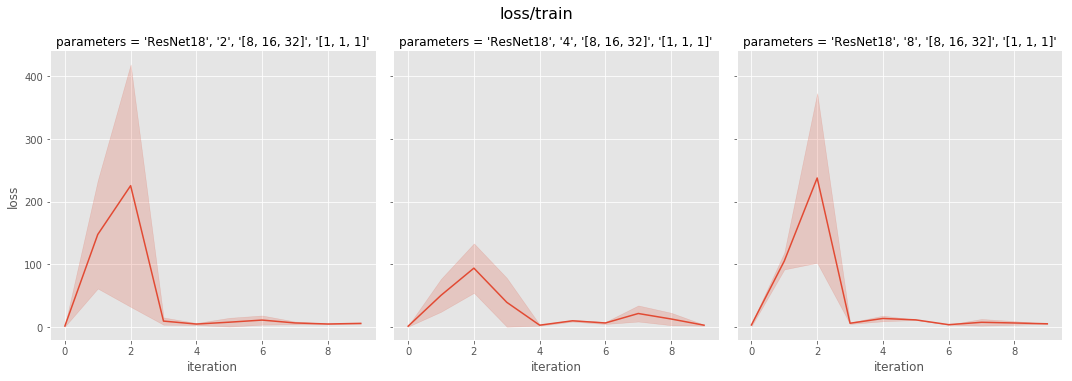

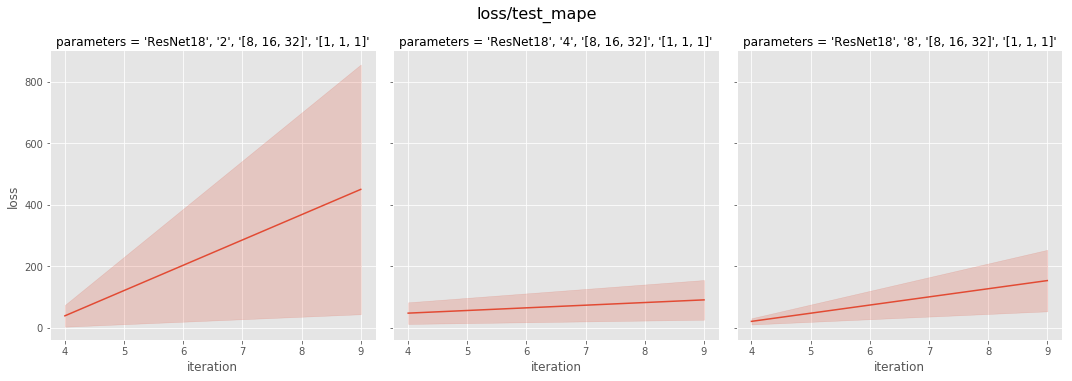

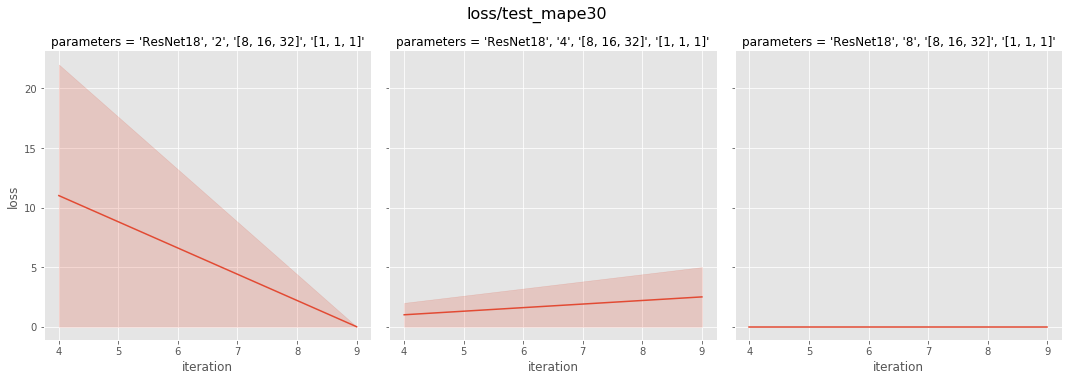

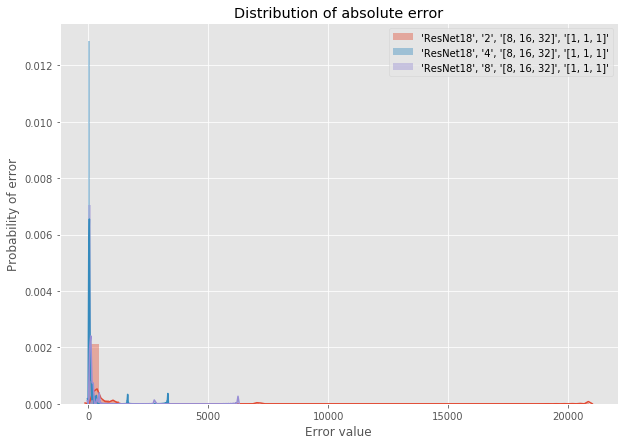

In [18]:
draw_stats(res[0], ['train', 'test_mape', 'test_mape30'], ['loss', 'metrics'], 'test_ape', 'metrics')